https://www.kaggle.com/nadintamer/titanic-survival-predictions-beginner 

# Data Exploration

Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

Import data

In [2]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

Now let's explore the data

In [3]:
len(train)

891

In [4]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Looks like there could be some empty cells.

In [6]:
train.isna().sum(axis = 0)

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

There are a lot of `Cabins` without numbers and some passenger `Ages` that are *NaN* too.

In [7]:
sum(train[['Age', 'Cabin']].isna().sum(axis = 1) == 2)

158

There are 158 passengers without both `Age` nor `Cabin` information.

# Pre-Analysis

**Class**

We have a guess that the class of a passenger is associated with someone's survival rate. Perhaps wealthier passengers got preference onto boats.

In [8]:
def percentage_class_survived(dat, var):
    bool_list = dat.loc[dat.Pclass == var]['Survived']
    rate = sum(bool_list) / len(bool_list)
    print(f"{rate} percent of {var}st class survived")

In [9]:
percentage_class_survived(train, 1)
percentage_class_survived(train, 2)
percentage_class_survived(train, 3)

0.6296296296296297 percent of 1st class survived
0.47282608695652173 percent of 2st class survived
0.24236252545824846 percent of 3st class survived


This looks plausible.

**Gender**

In [10]:
def percentage_gender_survived(dat, var):
    bool_list = dat.loc[dat.Sex == var]['Survived']
    rate = sum(bool_list) / len(bool_list)
    print(f"{rate} percent of {var}s survived")

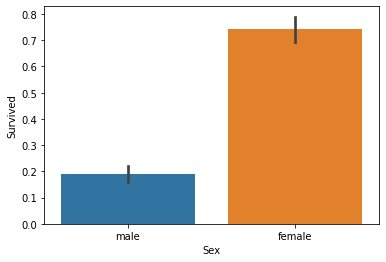

In [11]:
sns.barplot(x = 'Sex', y = 'Survived', data = train)
plt.show()

In [12]:
percentage_gender_survived(train, 'female')
percentage_gender_survived(train, 'male')

0.7420382165605095 percent of females survived
0.18890814558058924 percent of males survived


It seems like women are more likely to have survived off the Titanic.

**Pclass**

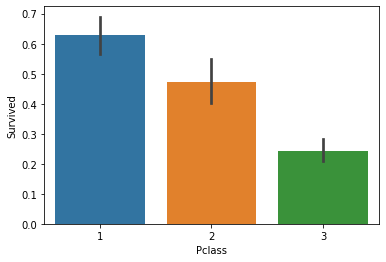

In [13]:
sns.barplot(x = 'Pclass', y = 'Survived', data = train)
plt.show()

It seems like the higher in class someone was, the more likely to survive (1 is highest).

**SibSp**

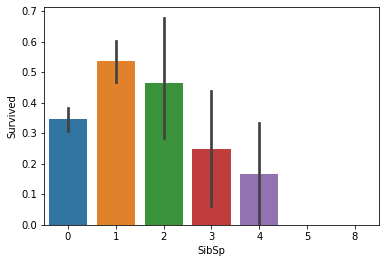

In [14]:
sns.barplot(x = 'SibSp', y = 'Survived', data = train)
plt.show()

It seems on average more siblings led to higher mortality. However, zero sublings was less likely to survive than 1 sibling.

**Parch**

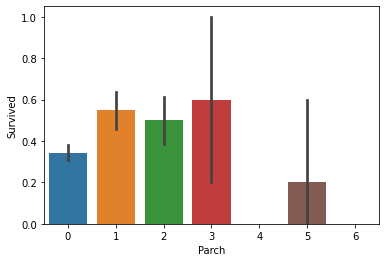

In [15]:
sns.barplot(x = 'Parch', y = 'Survived', data = train)
plt.show()

People traveling alone or with a family of 5 are less likely to survive.

**Age**

In [16]:
train['Age'] = train['Age'].fillna(-0.5)
test['Age'] = test['Age'].fillna(-0.5)
age_bins = [-1, 0, 5, 12, 18, 24, 35, 60, np.inf]
labels = ['Unknown', 'Baby', 'Child', 'Teenager', 
          'Student', 'Young Adult', 'Adult', 'Senior']
train['AgeGroup'] = pd.cut(train['Age'], age_bins, labels = labels)
test['AgeGroup'] = pd.cut(test['Age'], age_bins, labels = labels)

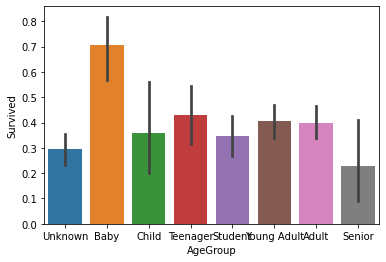

In [17]:
sns.barplot(x = 'AgeGroup', y = 'Survived', data = train)
plt.show()

Babies are more likely to survive.

# Clean Data

We'll drop `Cabin`, `Ticket`.

In [18]:
train = train.drop(['Cabin', 'Ticket'], axis = 1)
test = test.drop(['Cabin', 'Ticket'], axis = 1)

In [19]:
cities = ['Southampton', 'Cherbourg', 'Queens']
for city in cities:
    print(f"There are {train[train['Embarked'] == city[0]].shape[0]} people embarking from {city}")

There are 644 people embarking from Southampton
There are 168 people embarking from Cherbourg
There are 77 people embarking from Queens


Lets extract `Title`.

In [20]:
train['Title'] = train.Name.str.extract(' ([A-Za-z]+)\.', expand = False)
test['Title'] = test.Name.str.extract(' ([A-Za-z]+)\.', expand = False)

In [21]:
pd.crosstab(train['Title'], train['Sex'])

Sex,female,male
Title,,
Capt,0,1
Col,0,2
Countess,1,0
Don,0,1
Dr,1,6
Jonkheer,0,1
Lady,1,0
Major,0,2
Master,0,40


In [22]:
def combine_titles(dat):
        dat['Title'] = dat['Title'].replace(['Lady', 'Capt', 'Col', 'Don', 'Dr', 
                                       'Major', 'Rev', 'Jonkheer', 'Don'], 'Rare')
        dat['Title'] = dat['Title'].replace(['Countess', 'Lady', 'Sir'], 'Royal')
        dat['Title'] = dat['Title'].replace(['Mlle', 'Ms'], 'Miss')
        dat['Title'] = dat['Title'].replace('Mme', 'Mrs')

In [23]:
combine_titles(train)
combine_titles(test)

In [24]:
train[['Title', 'Survived']].groupby(['Title'], as_index = False).mean()

,Title,Survived
0,Master,0.575000
1,Miss,0.702703
2,Mr,0.156673
3,Mrs,0.793651
4,Rare,0.285714
5,Royal,1.000000


Looked like women and royalty had particularly high suvival rates.

In [25]:
def remake_titles(dat):
    title_mapping = title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Royal": 5, "Rare": 6}
    dat['Title'] = dat['Title'].map(title_mapping)
    dat['Title'] = dat['Title'].fillna(0)

Let's turn to other variables

Let's fill in missing `Age` values with the mode value

In [26]:
train['Age'] = train['Age'].fillna(train['Age'].mode())

Let's drop `Name`

In [27]:
train = train.drop(['Name', 'AgeGroup'], axis = 1)
test = test.drop(['Name', 'AgeGroup'], axis = 1)

Let's map `Sex` to values

In [28]:
sex_mapping = {"male": 0, "female": 1}
train['Sex'] = train['Sex'].map(sex_mapping)
test['Sex'] = test['Sex'].map(sex_mapping)

Let's map `Embarked` to values

In [29]:
embarked_mapping = {"S": 1, "C": 2, "Q": 3}
train['Embarked'] = train['Embarked'].map(embarked_mapping)
test['Embarked'] = test['Embarked'].map(embarked_mapping)

Let's fill in the mode value for missing `Fare` values

In [30]:
train['Fare'] = train['Fare'].fillna(train['Fare'].mode())
test['Fare'] = test['Fare'].fillna(test['Fare'].mode())

Let's map `Title` values

In [31]:
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Royal": 5, "Rare": 6}
train['Title'] = train['Title'].map(title_mapping)
test['Title'] = test['Title'].fillna(0)

In [32]:
train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,1,0,3,0,22.0,1,0,7.2500,1.0,1
1,2,1,1,1,38.0,1,0,71.2833,2.0,3
2,3,1,3,1,26.0,0,0,7.9250,1.0,2
3,4,1,1,1,35.0,1,0,53.1000,1.0,3
4,5,0,3,0,35.0,0,0,8.0500,1.0,1


# Testing Models

Now let's split the data

In [45]:
from sklearn.ensemble import RandomForestClassifier

y = train["Survived"]

features = ["Pclass", "Sex", "SibSp", "Parch"]
X = pd.get_dummies(train[features])
X_test = pd.get_dummies(test[features])

model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=1)
model.fit(X, y)
predictions = model.predict(X_test)

output = pd.DataFrame({'PassengerId': test.PassengerId, 'Survived': predictions})
output.to_csv('my_submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!
